# Problem Statement

Company is not able to identify the applicants profile properly before loan approval and hence they are facing both business and financial loss.

# Objective

The aim is to identify patterns which indicate if a person is likely to default, which may be used for taking actions such as denying the loan, reducing the amount of loan, lending (to risky applicants) at a higher interest rate, etc.

# Data Sourcing

Campany already given the dataset contains the information about past loan applicants and whether they ‘defaulted’ or not.

For this case study we need to focus only on provided dataset given by company.

In [23]:
# Importing usefull libraries to perform analysis

import pandas as pd
import seaborn as sns;
import matplotlib.pyplot as plt
import numpy as np

In [24]:
# Read and store the dataset
# loan_ds : loan dataset
loan_ds = pd.read_csv('loan.csv', header=0, low_memory=False)

In [25]:
# Shape of loan dataset
loan_ds.shape

(39717, 111)

In [26]:
# setting to display all rows & columns
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

# Data Cleaning

Lets clean the data before doing the analysis

## Fixing Rows and Columns

Checking null values

In [27]:
loan_ds.isnull().sum().sort_values(ascending=False)

verification_status_joint         39717
annual_inc_joint                  39717
mo_sin_old_rev_tl_op              39717
mo_sin_old_il_acct                39717
bc_util                           39717
bc_open_to_buy                    39717
avg_cur_bal                       39717
acc_open_past_24mths              39717
inq_last_12m                      39717
total_cu_tl                       39717
inq_fi                            39717
total_rev_hi_lim                  39717
all_util                          39717
max_bal_bc                        39717
open_rv_24m                       39717
open_rv_12m                       39717
il_util                           39717
total_bal_il                      39717
mths_since_rcnt_il                39717
open_il_24m                       39717
open_il_12m                       39717
open_il_6m                        39717
open_acc_6m                       39717
tot_cur_bal                       39717
tot_coll_amt                      39717


By looking at the above insight:
1. From column **verification_status_joint** to **mths_since_last_major_derog** : Number of null is same as number of rows in data set. i.e. These columns having only null values. We can get rid of these columns
2. Column **mths_since_last_record** and **mths_since_last_delinq** : Very large number of null
3. Column **desc** is containing plan text. We can get rid of this as well. we can check the different values by loan_ds.desc.value_counts().

Get the total null value for desc column from above insight

In [28]:
total_null_desc = 12940
loan_ds_1 = loan_ds.loc[:, loan_ds.isnull().sum() < total_null_desc]

By looking at the head and tail seems like many columns contains lot of zeroes. Please check loan_ds_1.head(40) and loan_ds_1.tail(40)

Checking zero values

In [29]:
loan_ds_1.isin([0]).sum().sort_values(ascending=False)

delinq_amnt                   39717
acc_now_delinq                39717
tax_liens                     39678
chargeoff_within_12_mths      39661
collections_12_mths_ex_med    39661
out_prncp_inv                 38577
out_prncp                     38577
total_rec_late_fee            37671
pub_rec                       37601
pub_rec_bankruptcies          37339
collection_recovery_fee       35935
recoveries                    35499
delinq_2yrs                   35405
inq_last_6mths                19300
revol_bal                       994
dti                             183
total_pymnt_inv                 165
funded_amnt_inv                 129
total_rec_prncp                  74
last_pymnt_amnt                  74
total_rec_int                    71
total_pymnt                      16
last_pymnt_d                      0
sub_grade                         0
grade                             0
installment                       0
verification_status               0
int_rate                    

By looking at the above insight:
1. From column **delinq_amnt** to **delinq_2yrs** : Number of zero is very closer to or almost same as number of rows in data set. i.e. These columns having mostly zero values. We can get rid of these columns
2. Column **inq_last_6mths** (Inquiry in last six months) : this columns is not looking useful to analysis we perform. We can get rid of this coulmn as well.

Get the total zero value for inq_last_6mths column from above insight

In [30]:
total_zero_inq_last_6mths = 19300
loan_ds_2 = loan_ds_1.loc[:, loan_ds_1.isin([0]).sum() < total_zero_inq_last_6mths]

loan id should be unique

In [31]:
loan_ds_2.id.nunique() == loan_ds_2.shape[0]

True

Borrower member id should be unique

In [32]:
loan_ds_2.member_id.nunique() == loan_ds_2.shape[0]

True

Get rid of percentage sign and convert to float for int_rate columns

In [33]:
loan_ds_2['int_rate'] = loan_ds_2.int_rate.apply(lambda x: float(x[0:-1]))

/var/folders/7_/8px52ys552g8ncjsx6czydyh0000gn/T/ipykernel_33861/2618902194.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  loan_ds_2['int_rate'] = loan_ds_2.int_rate.apply(lambda x: float(x[0:-1]))


In [34]:
loan_ds_2.home_ownership.value_counts()

RENT        18899
MORTGAGE    17659
OWN          3058
OTHER          98
NONE            3
Name: home_ownership, dtype: int64

As per data dictonary possible values for home_ownership are RENT, OWN, MORTGAGE and OTHER. But in data set NONE is also present. Hence moving NONE to OTHER

In [35]:
loan_ds_2.home_ownership = loan_ds_2.home_ownership.apply(lambda x: 'OTHER' if x == 'NONE' else x)

/var/folders/7_/8px52ys552g8ncjsx6czydyh0000gn/T/ipykernel_33861/980230692.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  loan_ds_2.home_ownership = loan_ds_2.home_ownership.apply(lambda x: 'OTHER' if x == 'NONE' else x)


Get rid of percentage sign and convert to float for revol_util columns

In [36]:
loan_ds_2['revol_util'] = loan_ds_2.revol_util.apply(lambda x: float(str(x).rstrip('%')))

/var/folders/7_/8px52ys552g8ncjsx6czydyh0000gn/T/ipykernel_33861/3734154491.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  loan_ds_2['revol_util'] = loan_ds_2.revol_util.apply(lambda x: float(str(x).rstrip('%')))


## Univariate Analysis

### Unordered Categorical Variable

Important Unordered categorical variable present in dataset are 
1. home_ownership
2. verification_status
3. loan_status
4. purpose
5. addr_state

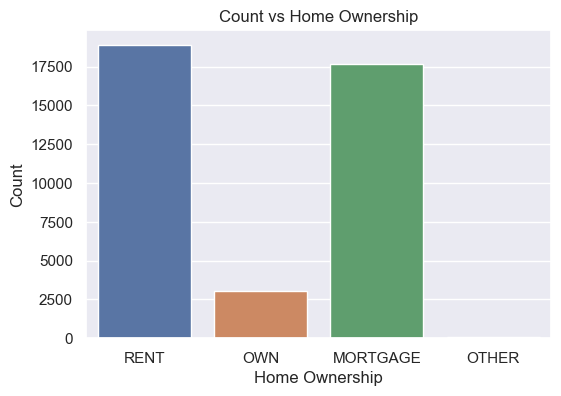

In [105]:
plt.figure(figsize=(6, 4))
sns.set_style("darkgrid")
sns.countplot(data=loan_ds_2, x='home_ownership')
plt.xlabel('Home Ownership')
plt.ylabel('Count')
plt.title('Count vs Home Ownership')
plt.show()

**Note**: There are many people belong to mortgage category. That mean they already borrowed the money from some other sources.

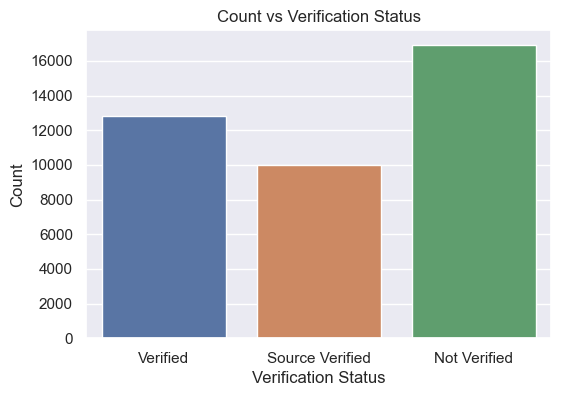

In [107]:
plt.figure(figsize=(6, 4))
sns.set_style("darkgrid")
sns.countplot(data=loan_ds_2, x='verification_status')
plt.xlabel('Verification Status')
plt.ylabel('Count')
plt.title('Count vs Verification Status')
plt.show()

**Note**: More than 16000 loans are not verified.

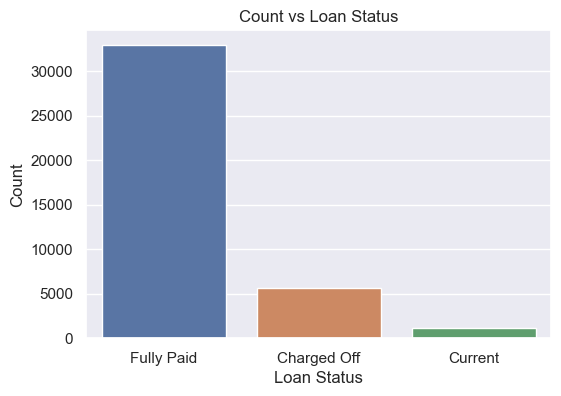

In [109]:
plt.figure(figsize=(6, 4))
sns.set_style("darkgrid")
sns.countplot(data=loan_ds_2, x='loan_status')
plt.xlabel('Loan Status')
plt.ylabel('Count')
plt.title('Count vs Loan Status')
plt.show()

**Note**: More than 5000 loans have Charged Off out of approximately 37000

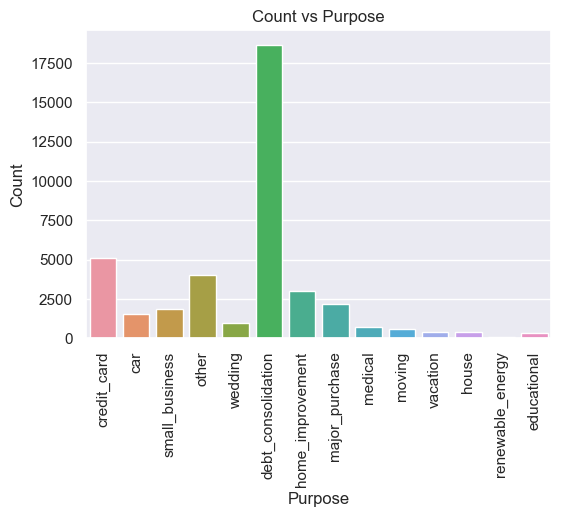

In [113]:
plt.figure(figsize=(6, 4))
sns.set_style("darkgrid")
sns.countplot(data=loan_ds_2, x='purpose')
plt.xlabel('Purpose')
plt.xticks(rotation=90)
plt.ylabel('Count')
plt.title('Count vs Purpose')
plt.show()

**Note**: People are taking loan mostly to do debt consolidation followed by credit card, home improvement and major purchase.

Question:
1. What is Major Purchase?
2. What is other (do remember other is the third most purpose)?

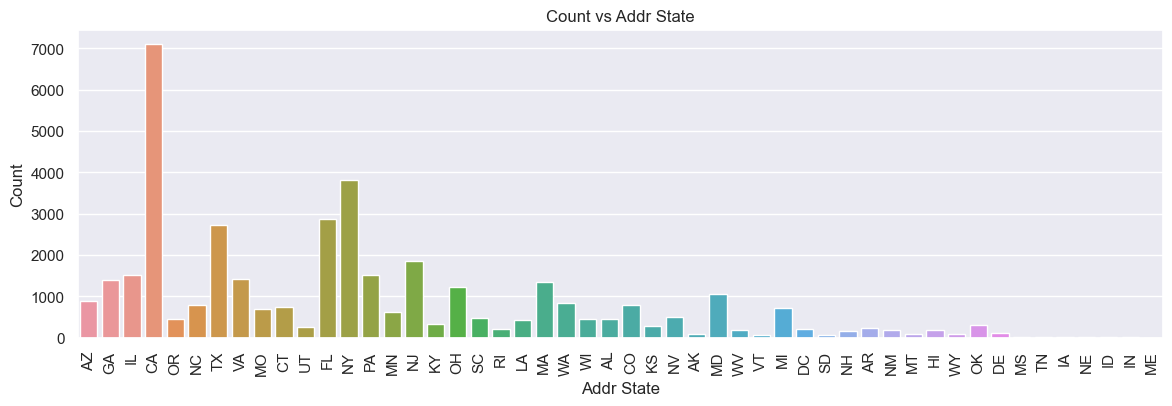

In [116]:
plt.figure(figsize=(14, 4))
sns.set_style("darkgrid")
sns.countplot(data=loan_ds_2, x='addr_state')
plt.xlabel('Addr State')
plt.xticks(rotation=90)
plt.ylabel('Count')
plt.title('Count vs Addr State')
plt.show()

**Note**: 
1. People from state with code CA, NY, FL, TX and NJ are the top 5 for having loans. 
2. People from state with code UT, RI, AK, VT, SD etc are less intrested in having loans. 